In [84]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.spatial import distance as dist
%matplotlib inline

In [113]:
im_reg = cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\rad_625_04_iter_500_time_4294.tif')
im_ir =  cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\fixed_resized.png')

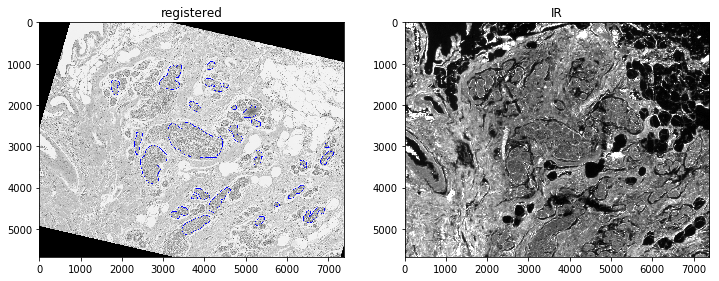

In [114]:
plt.figure(figsize = (12,12))
plt.subplot(1,2,1)
plt.title('registered')
plt.imshow(im_reg, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('IR')
plt.imshow(im_ir, cmap = 'gray')

In [115]:
cnt_pos = np.where(im_reg[:,:,2] == 255)
print(np.array(cnt_pos).shape)

(2, 297255)


In [116]:
cord_list = [] #list of the coordinates
for a, b in zip(cnt_pos[0], cnt_pos[1]):
    cord_list.append([a,b])

In [117]:
cnt_pos

(array([ 952,  952,  952, ..., 5149, 5149, 5149], dtype=int64),
 array([4158, 4159, 4160, ..., 3624, 3625, 3626], dtype=int64))

In [118]:
im_reg_gray = cv2.cvtColor(im_reg, cv2.COLOR_BGR2GRAY)
M1 = np.zeros_like(im_reg_gray)

In [119]:
x, y = zip(*cord_list)

In [120]:
x1 = list(cnt_pos[0])
x2 = list(cnt_pos[1])
M1[x1,x2] = 255

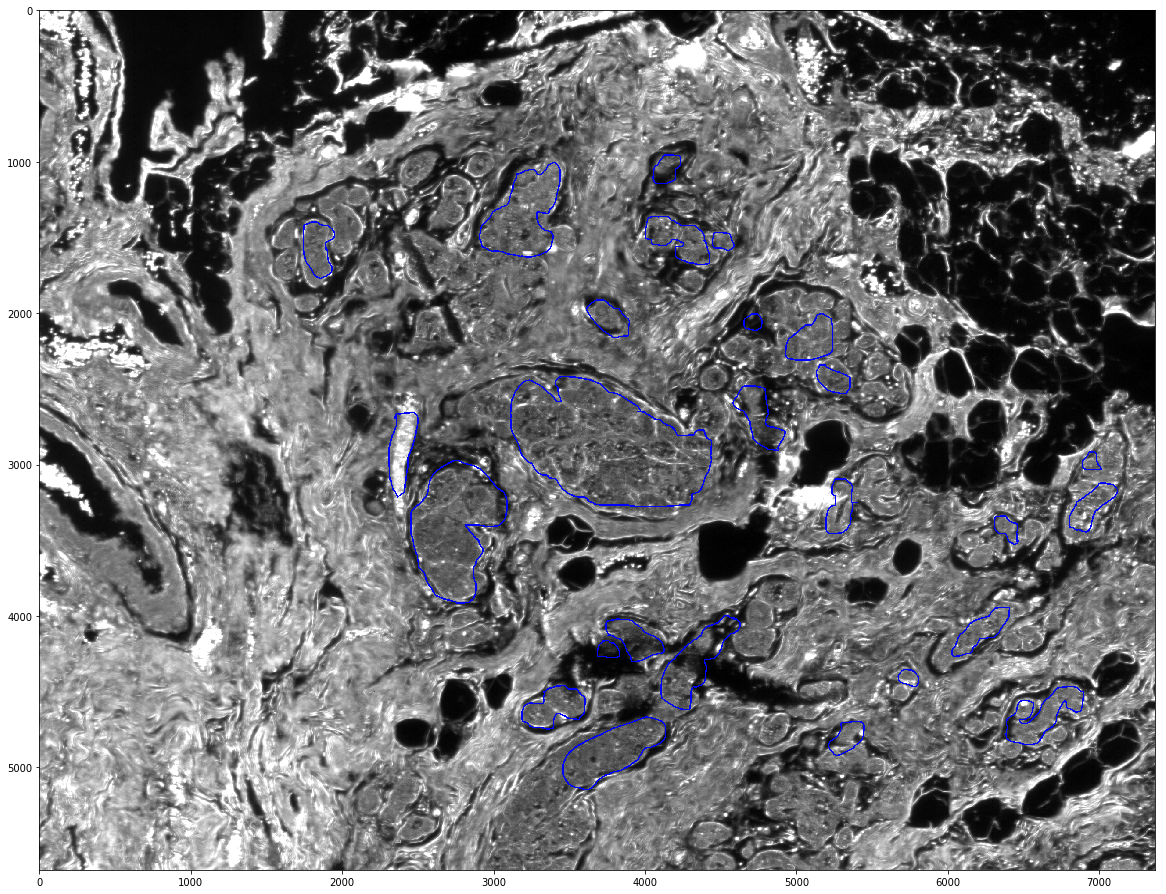

In [121]:
ir_marked = copy.deepcopy(im_ir)
ir_marked[x1, x2] = [0,0,255]
plt.figure(figsize = (20,20))
plt.imshow(ir_marked)

In [122]:
cv2.imwrite('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\ir_marked.png', ir_marked)

True

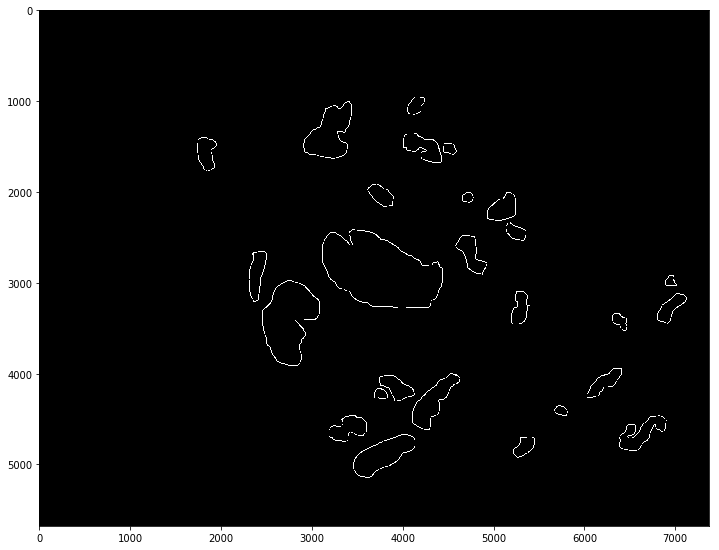

In [123]:
plt.figure(figsize = (12,12))
plt.imshow(M1, cmap = 'gray')
plt.show()

In [124]:
cntrs, _ = cv2.findContours(M1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [125]:
np.array(cntrs).shape

(26,)

In [126]:
direct = "D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\post_process\\roi_test"

In [127]:
# Didn't work for M[6], don't use fillConvexPoly, perhaps it's not able to fill some concave region
M = []
idx = 24
for cnt in cntrs:
    M3 = np.zeros_like(im_reg_gray)
    filename = os.path.join(direct, str(idx) + ".png")
    cv2.drawContours(M3, cnt, -1, (255,255,255),15)
    M.append(cv2.fillConvexPoly(M3, cnt, 255))
    cv2.imwrite(filename, M3)
    idx += 1

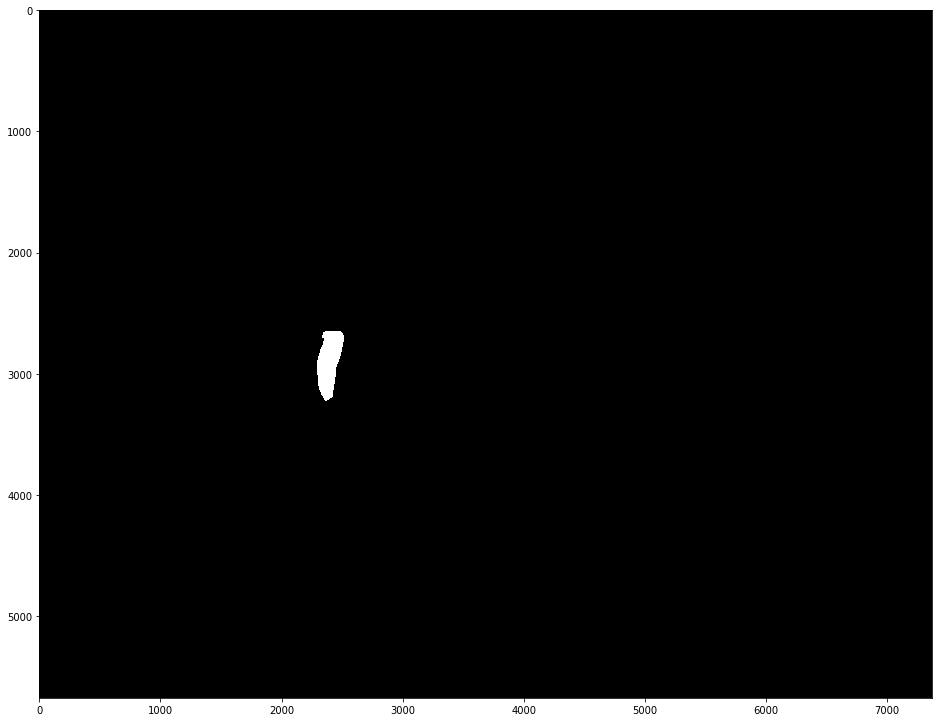

In [128]:
plt.figure(figsize = (16,16))
plt.imshow(M[14], cmap = 'gray')

In [129]:
# this method worked
# TODO - Try to find out difference between fillPoly, and fillConvexPoly and drawContours with flag FILLED
#cv2.drawContours also didn't work
M6 = []
idx = 0
for cnt in cntrs:
    M3 = np.zeros_like(im_reg_gray)
    filename = os.path.join(direct, str(idx) + ".png")
    #cv2.drawContours(M3, cnt, -1, (255,255,255),thickness = cv2.FILLED) #don't use it
    cv2.fillPoly(M3, [cnt], (255,255,255))
    M6.append(M3)
    cv2.imwrite(filename, M3)
    idx += 1

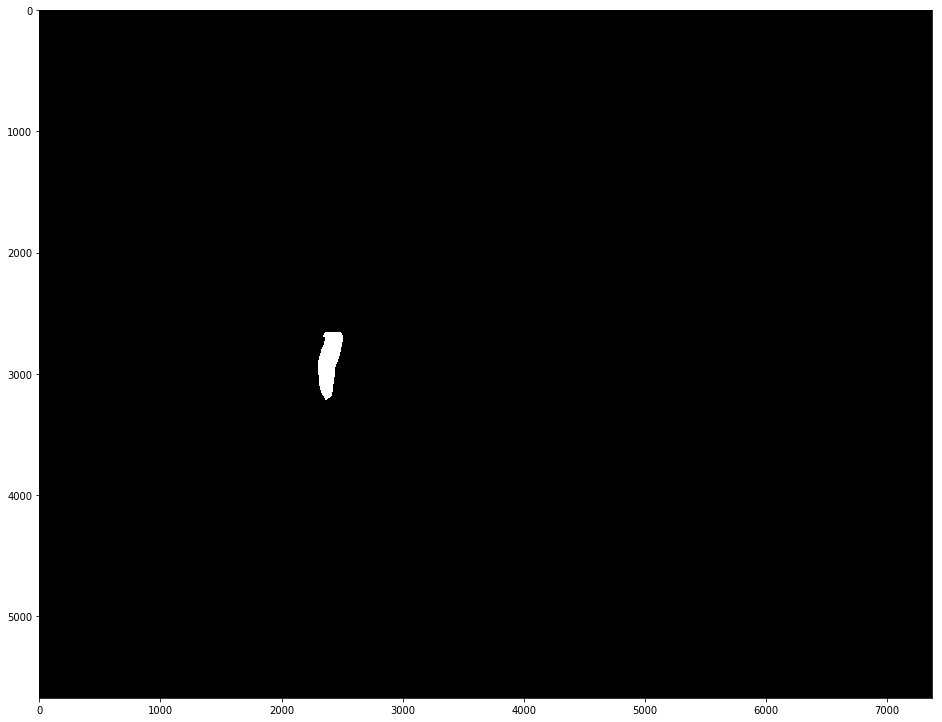

In [130]:
plt.figure(figsize = (16,16))
plt.imshow(M6[14], cmap = 'gray')

## Crop the images from registered and IR image to compare

In [131]:
#x, y, w, h = cv2.boundingRect(cnt)
reg1 = cv2.imread('D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\reg_final.tif')

In [132]:
im_ir.shape

(5677, 7372, 3)

In [133]:
R = []
IR = []
reg_gray = cv2.cvtColor(reg1, cv2.COLOR_BGR2GRAY)
ir_gray = cv2.cvtColor(im_ir, cv2.COLOR_BGR2GRAY)
for im in M6:
    R1 = cv2.bitwise_and(reg_gray,im)
    IR1 = cv2.bitwise_and(ir_gray, im)
    R.append(R1)
    IR.append(IR1)

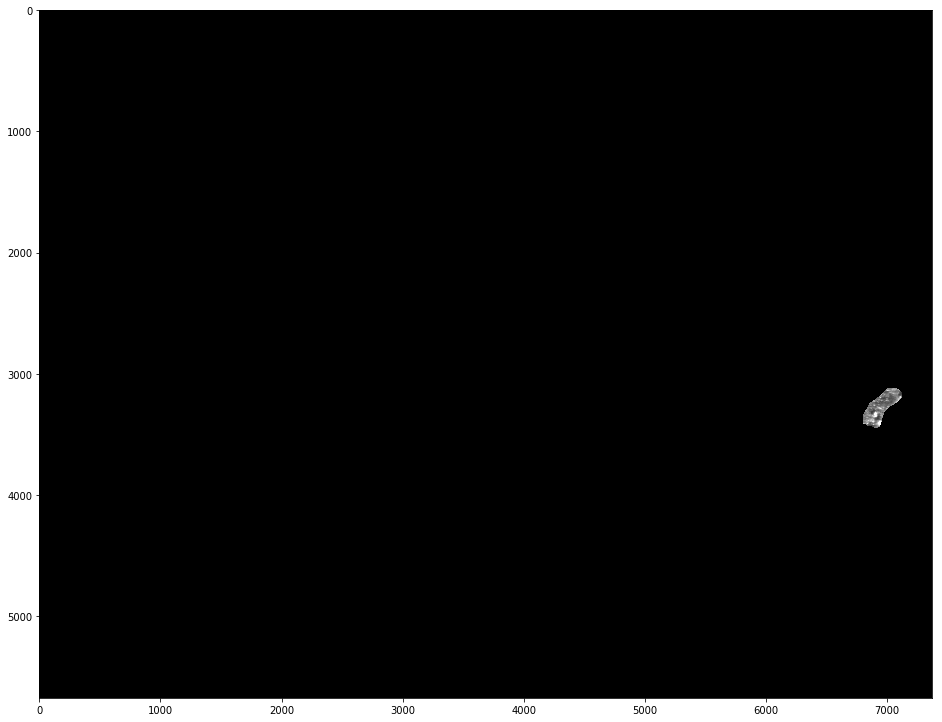

In [134]:
plt.figure(figsize = (16,16))
plt.imshow(IR[10], cmap = 'gray')

In [135]:
path1 = 'D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\compare'

In [136]:
i = 0
P_reg = [] # registered patches
P_ir = [] # ir image patches
for cnt in cntrs:
    x, y, w, h = cv2.boundingRect(cnt)
    f1 = os.path.join(path1, str(i) + "reg.png")
    f2 = os.path.join(path1, str(i) + "ir.png")
    reg = R[i][y:y+h, x:x+w]
    
    
    P_reg.append(reg)
    ir = IR[i][y:y+h, x:x+w]
    P_ir.append(ir)
    cv2.imwrite(f1, reg)
    cv2.imwrite(f2, ir)
    i += 1

### Hist plot of complete image matrix

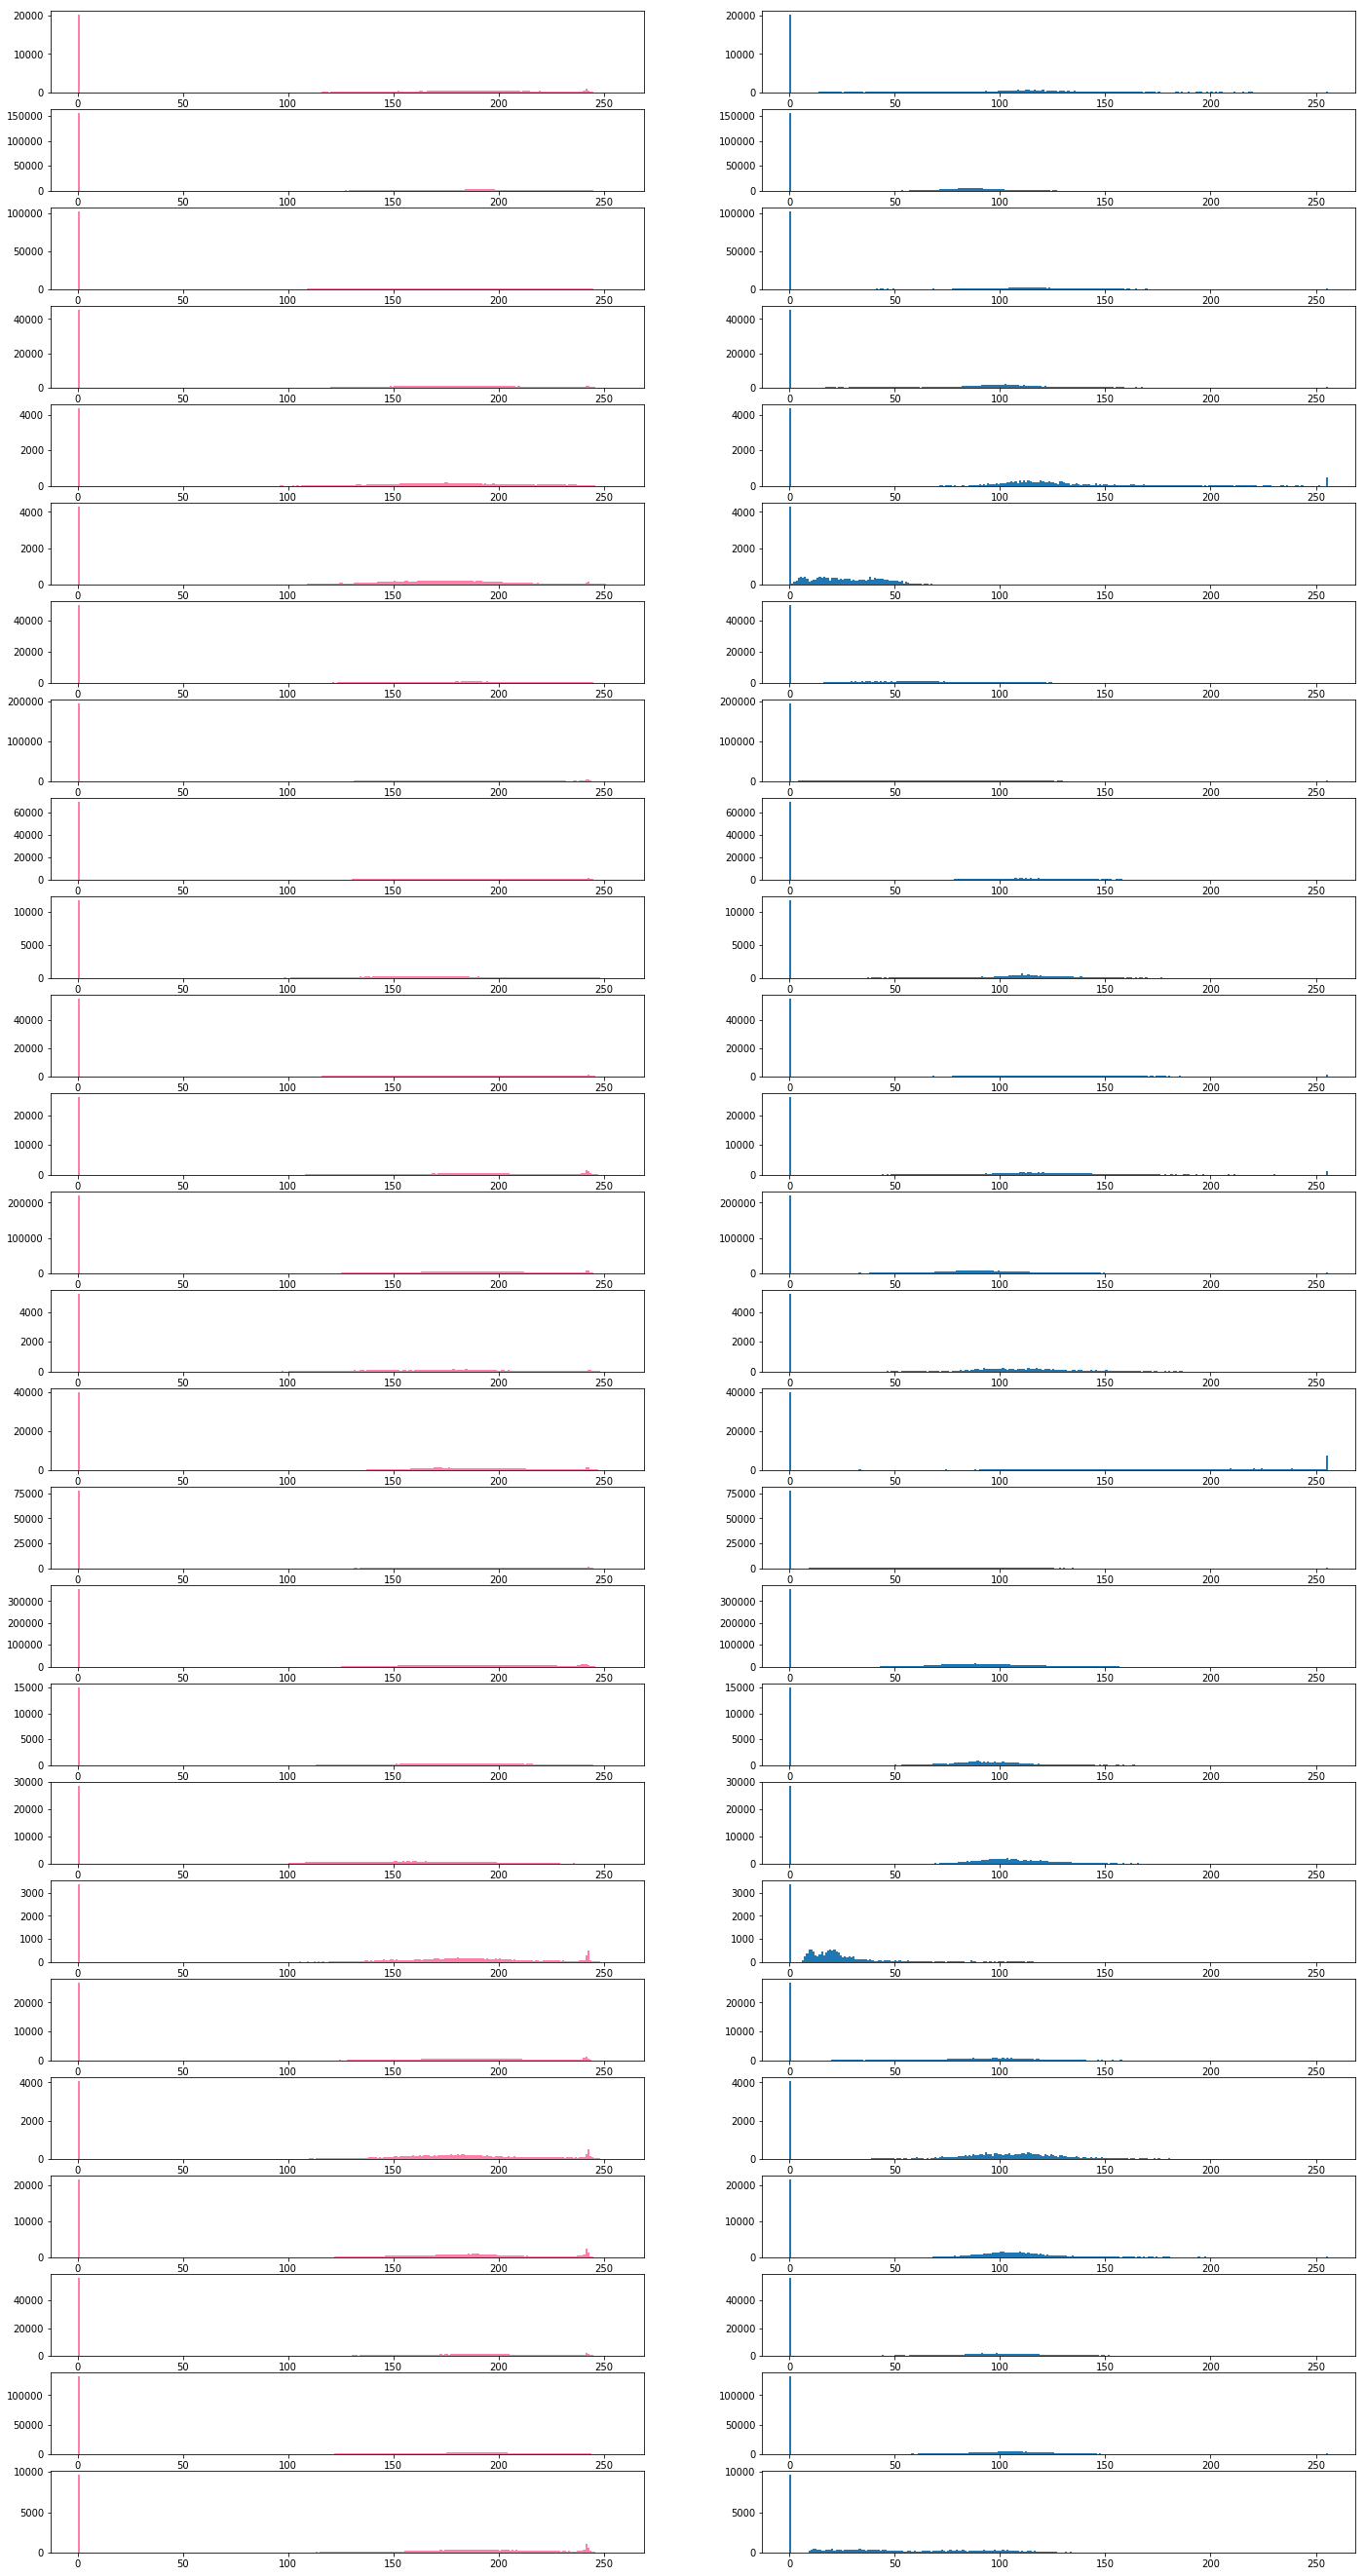

In [138]:
i = 1
plt.figure(figsize = (24,48))
for h1, h2 in zip(P_reg, P_ir):
    plt.subplot(26,2,i)
    plt.hist(h1.ravel(), 256, [0,256], color = '#ff7fa7')
    i+=1
    plt.subplot(26,2,i)
    plt.hist(h2.ravel(), 256, [0,256])
    i+=1

## Set the threshold using histogram matching
### OpenCV Methods

In [139]:
h_ir = []
h_reg = []
for r, i in zip(P_reg, P_ir):
    #r1 = cv2.bitwise_not(r)
    h1 = cv2.calcHist(r, [0], None, [256], [0,256])
    h1 = cv2.normalize(h1, h1).flatten()
    h_reg.append(h1)
    
    #i1 = cv2.bitwise_not(r)
    h11 = cv2.calcHist(i, [0], None, [256], [0,256])
    h11 = cv2.normalize(h11, h11).flatten()
    h_ir.append(h11)

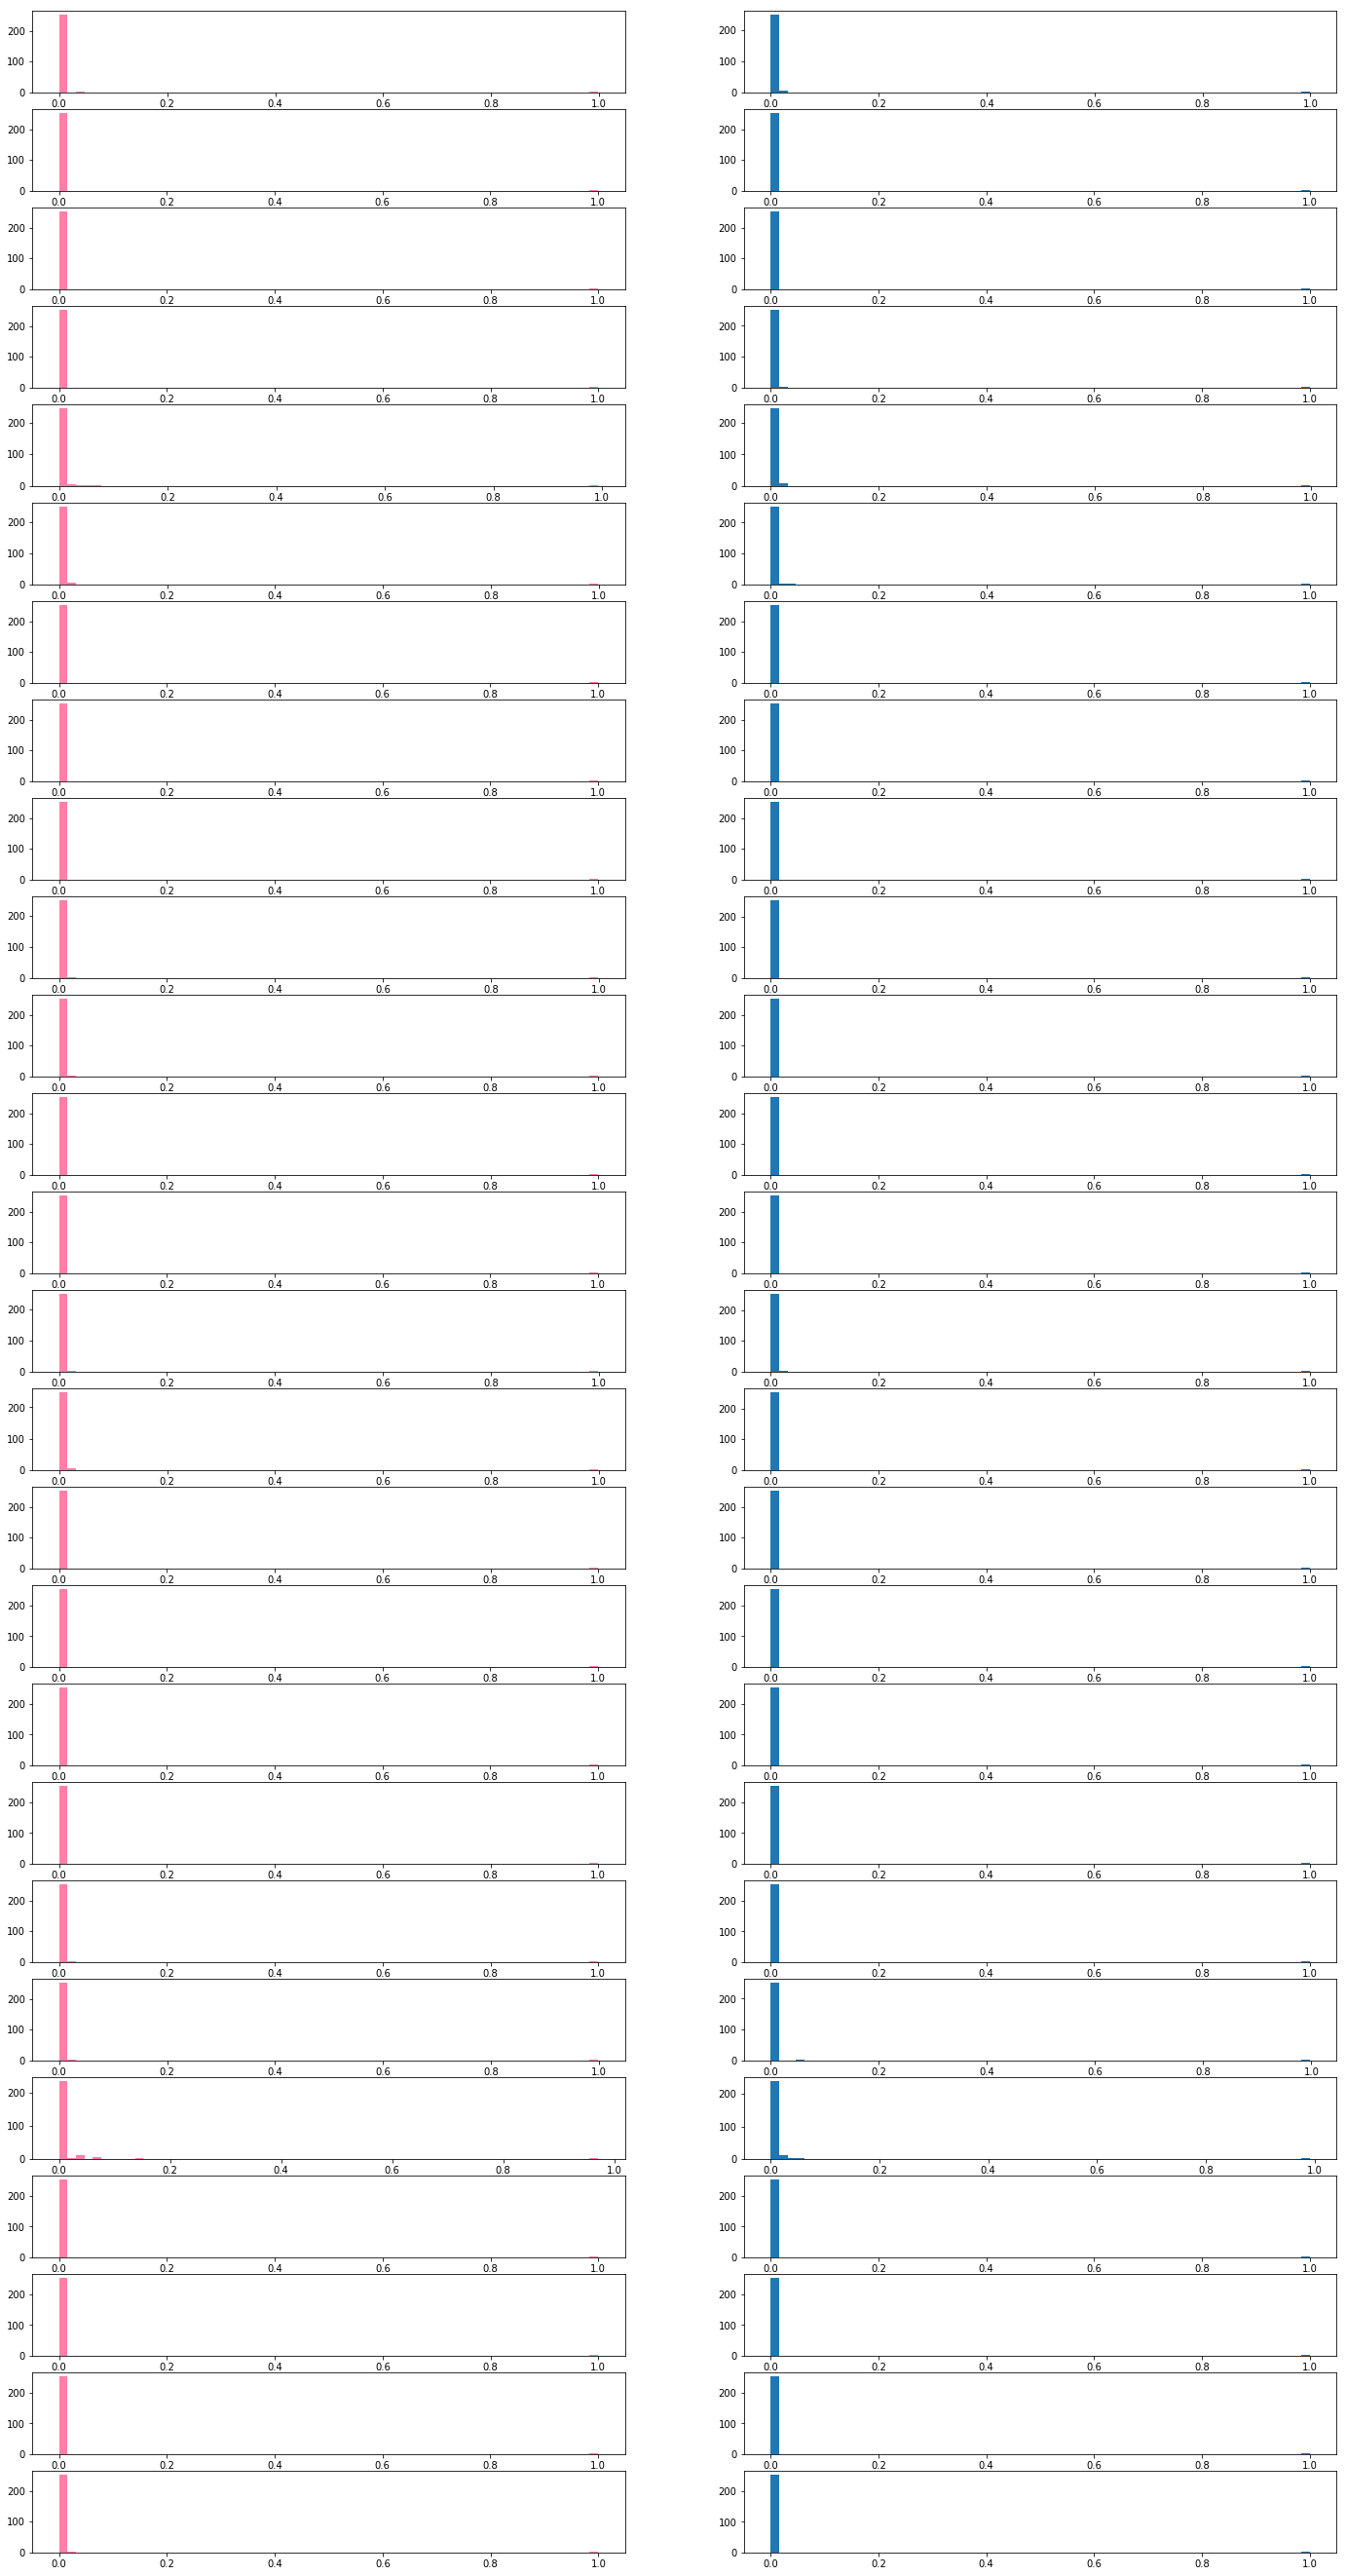

In [141]:
#results = []
i = 1
plt.figure(figsize = (24,48))
for h1, h2 in zip(h_ir, h_reg):
    plt.subplot(26 ,2,i)
    plt.hist(h1, bins = 64, color = '#ff7fa7')
    i+=1
    plt.subplot(26,2,i)
    plt.hist(h2, bins = 64)
    i+=1

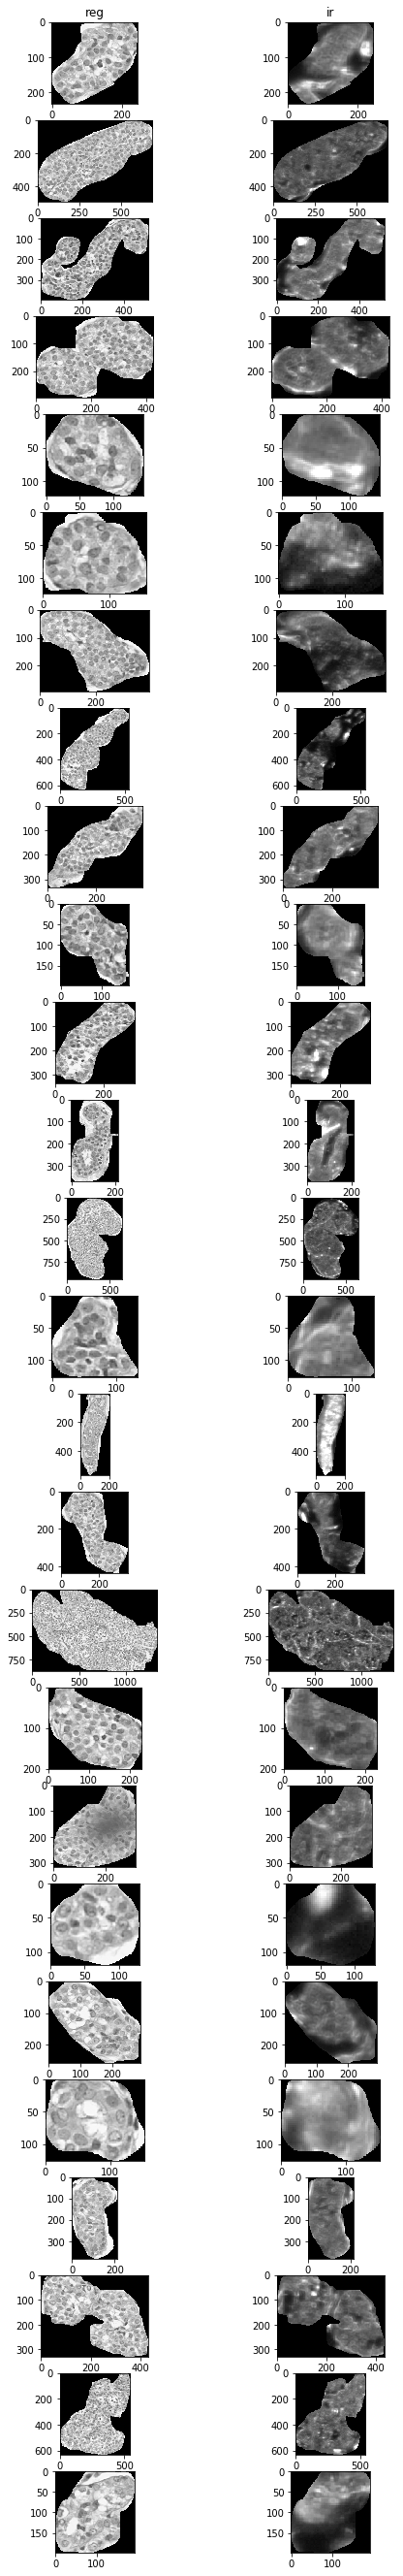

In [143]:
idx = 1
plt.figure(figsize = (8,48))
for r, i in zip(P_reg, P_ir):
    plt.subplot(26,2,idx)
    if(idx == 1):
        plt.title('reg')
    plt.imshow(r, cmap = 'gray')
    idx+=1
    plt.subplot(26,2,idx)
    if(idx == 2):
        plt.title('ir')
    plt.imshow(i, cmap = 'gray')
    idx+=1

In [144]:
i = 0
methods = [cv2.HISTCMP_CORREL, cv2.HISTCMP_CHISQR, cv2.HISTCMP_INTERSECT, cv2.HISTCMP_BHATTACHARYYA ]
# cv2.HISTCMP_CHISQR and cv2.HISTCMP_BHATTACHARYYA -  minimum is the better other two reverse
results = [ [] for i in range(len(methods)) ]
for method in methods:
    for h1, h2 in zip(h_ir, h_reg):
        d = cv2.compareHist(h1, h2, method)
        results[i].append(d)
    i += 1
res_arr = np.array(results)
print(res_arr)

[[0.99677271 0.99997619 0.999772   0.99929551 0.99060857 0.99794065
  0.99993262 0.99988255 0.99990368 0.99902679 0.99937676 0.99927231
  0.99987819 0.99898881 0.99838494 0.99974961 0.99998915 0.99986241
  0.99976868 0.99975104 0.99589818 0.9612     0.99976797 0.99965789
  0.99991031 0.99947218]
 [0.17035973 0.00734204 0.04190992 0.05954097 0.32796074 0.09779695
  0.0129528  0.01720769 0.01570584 0.07786971 0.07367171 0.06497161
  0.02384542 0.06344826 0.13469148 0.03811743 0.00678729 0.01769739
  0.03235772 0.02361839 0.12393258 0.88636757 0.02403486 0.058665
  0.02268285 0.03782192]
 [1.00771668 0.99998593 0.99985069 0.99950778 0.99292159 0.99892592
  0.99995637 0.99992502 0.99993837 0.99932605 1.00283164 0.9995628
  0.99991786 0.99930781 0.99896008 0.99984956 0.99999344 0.99990213
  0.99985343 0.99984503 0.99675584 0.97092813 0.9998498  0.999749
  0.99993569 0.99957663]
 [0.38092535 0.08537347 0.20057389 0.23707823 0.49827288 0.29861677
  0.11308282 0.1300665  0.124354   0.26886643 

### Scipy Methods

In [145]:
i = 0
sc_methods = [dist.euclidean, dist.cityblock, dist.chebyshev]# in all three minimum is better
results_sc = [ [] for i in range(len(sc_methods)) ]
for method in sc_methods:
    for h1, h2 in zip(h_ir, h_reg):
        d = method(h1, h2)
        results_sc[i].append(d)
    i += 1
res_arr_sc = np.array(results_sc)
print(res_arr_sc)

[[0.08012109 0.00688746 0.02130899 0.03745395 0.13658108 0.06402618
  0.01158544 0.01529544 0.01385141 0.04401813 0.03522524 0.03806478
  0.01557604 0.04487148 0.05669122 0.0223308  0.00464885 0.01655477
  0.02146426 0.02226823 0.09035125 0.2766569  0.02149806 0.02610038
  0.0133662  0.03242232]
 [0.34774905 0.01468846 0.08389446 0.11934787 0.66227823 0.19570088
  0.02592601 0.03444777 0.03143952 0.15614757 0.15204766 0.13010275
  0.04773483 0.12729761 0.2699185  0.07628845 0.01357691 0.03545452
  0.06478023 0.04730023 0.24995939 1.80942667 0.04814063 0.11750077
  0.04540587 0.07597694]
 [0.04339429 0.00440522 0.01197426 0.02480168 0.07287498 0.03493089
  0.00777168 0.00955951 0.00785292 0.01946739 0.01979271 0.01499569
  0.00953817 0.02379304 0.01683641 0.00879678 0.00226243 0.01327304
  0.00970792 0.01574559 0.06181432 0.14563923 0.01442091 0.01466624
  0.00567071 0.02701558]]


### Modified Chi Squared distance

In [146]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])
    # return the chi-squared distance
    return d

In [147]:
res1 = []
for h1, h2 in zip(h_ir, h_reg):
    d = chi2_distance(h1, h2)
    res1.append(d)
res1_arr = np.array(res1)
print(res1_arr)

[0.17169191 0.00734206 0.04191141 0.05953248 0.32873813 0.09780171
 0.01295293 0.01720741 0.01570605 0.07788436 0.07423284 0.06497646
 0.02384593 0.06346013 0.13472315 0.03811842 0.00678729 0.0176979
 0.03235873 0.02361912 0.12377916 0.89501182 0.02403568 0.05866972
 0.0226833  0.03782792]


## Set the threshold using cnn features embedding similarity
### Method 1: Fine Tune VGG16 for two class

In [148]:
image_size = 224

In [176]:
from keras.applications import VGG16
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top = False, input_shape=(image_size, image_size, 3))

In [177]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x000001CE0CAE0A58> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0CAE0A20> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0CAE0B38> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE0CDE45C0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0CDEAE80> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0CFB7240> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE0CFAA240> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D0F2748> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D0F25C0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D0C4DA0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE0D1158D0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D110DA0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D1108D0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE0D24F390> False
<keras.

In [193]:
print(vgg_conv.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [178]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [179]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import decode_predictions

In [180]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

### Convert grayscale image to RGB

In [181]:
direct = "D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\cnn_training"

In [182]:
idx = 0
for r, i in zip(P_reg, P_ir):
    r1 = cv2.cvtColor(r, cv2.COLOR_GRAY2RGB)
    #print(r1.shape)
    fn1 = os.path.join(direct1, str(idx) + "reg.png")
    #print(fn1)
    #cv2.imwrite(fn1, r1)
    fn2 = os.path.join(direct1, str(idx) + "ir.png")
    i1 = cv2.cvtColor(i, cv2.COLOR_GRAY2RGB)
    #cv2.imwrite(fn2, i1)
    idx += 1

In [183]:
train_generator = train_datagen.flow_from_directory(
        direct1,
        target_size=(image_size, image_size),
        batch_size=8,
        class_mode='categorical')

Found 52 images belonging to 2 classes.


In [184]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=10)
 
# Save the model
model.save('small_last4.h5')

Epoch 1/10
7/6 [================================] - 28s 4s/step - loss: 1.5106 - acc: 0.5901
Epoch 2/10
7/6 [================================] - 27s 4s/step - loss: 0.3645 - acc: 0.8041
Epoch 3/10
7/6 [================================] - 27s 4s/step - loss: 0.2572 - acc: 0.8558
Epoch 4/10
7/6 [================================] - 27s 4s/step - loss: 0.4560 - acc: 0.8582
Epoch 5/10
7/6 [================================] - 27s 4s/step - loss: 0.2209 - acc: 0.9099
Epoch 6/10
7/6 [================================] - 27s 4s/step - loss: 0.2612 - acc: 0.9123
Epoch 7/10
7/6 [================================] - 27s 4s/step - loss: 0.2032 - acc: 0.8558
Epoch 8/10
7/6 [================================] - 27s 4s/step - loss: 0.2427 - acc: 0.9279
Epoch 9/10
7/6 [================================] - 27s 4s/step - loss: 0.1915 - acc: 0.9099
Epoch 10/10
7/6 [================================] - 27s 4s/step - loss: 0.2261 - acc: 0.9459


### Method 2 : Get feature vectors of resnet50 and find the difference

In [185]:
path_to_image = 'D:\\ShachiLab\\Mukul\\Registration_matlab\\results\\registered\\all_patches'

In [191]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from os import listdir, walk
from os.path import isfile, join, basename, splitext


def getAllFilesInDirectory(directoryPath):
    return [(directoryPath + "/" + f) for f in listdir(directoryPath) if isfile(join(directoryPath, f))]

def predict(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x)

def findDifference(f1, f2):
    return np.linalg.norm(f1-f2)

def get_features():
    model = ResNet50(weights='imagenet')
    feature_vectors = {}
    for img_path in getAllFilesInDirectory(path_to_image):
        base_name = basename(img_path)
        key = splitext(base_name)[0]
        feature_vectors[key] = predict(img_path, model)[0]
    return feature_vectors

In [192]:
all_feature = get_features()

In [203]:
all_images = getAllFilesInDirectory(path_to_image)
key_ir = [splitext(basename(img_path))[0] for img_path in all_images if 'ir.png' in img_path]
key_reg = [splitext(basename(img_path))[0] for img_path in all_images if 'reg.png' in img_path]

In [209]:
diff_cnn = {}
for k1, k2 in zip(key_reg, key_ir):
    f1 = all_feature[k1]
    f2 = all_feature[k2]
    diff = findDifference(f1, f2)
    diff_cnn[k1 + k2] = diff

In [210]:
diff_cnn

{'0reg0ir': 1.285596,
 '10reg10ir': 0.7895482,
 '11reg11ir': 0.8763084,
 '12reg12ir': 0.49002665,
 '13reg13ir': 0.950217,
 '14reg14ir': 0.6016924,
 '15reg15ir': 0.8496434,
 '16reg16ir': 0.64216703,
 '17reg17ir': 0.9376592,
 '18reg18ir': 0.77035004,
 '19reg19ir': 0.9641862,
 '1reg1ir': 0.81945825,
 '20reg20ir': 0.783741,
 '21reg21ir': 0.69941556,
 '22reg22ir': 0.34326422,
 '23reg23ir': 0.97441036,
 '24reg24ir': 0.82549113,
 '25reg25ir': 0.17436011,
 '2reg2ir': 0.81518185,
 '3reg3ir': 0.93350285,
 '4reg4ir': 0.72868246,
 '5reg5ir': 0.9536237,
 '6reg6ir': 0.9472767,
 '7reg7ir': 0.9067809,
 '8reg8ir': 1.040474,
 '9reg9ir': 0.7586689}

## Extra Work

In [26]:
equ = cv2.equalizeHist(ir_gray)
#res = np.hstack((ir_gray,equ)) #stacking images side-by-side
f11 = os.path.join(path1, str(i) + "ir_equalized.png")
cv2.imwrite(f11, equ)

True

In [27]:
equ1 = cv2.bitwise_not(equ)
f12 = os.path.join(path1, "ir_not_equalized.png")
cv2.imwrite(f12, equ1)

True

In [47]:
I = cv2.imread('E:\\Mukul\\others\\stof.png')
I.shape

(701, 1250, 3)

In [48]:
I_cnt = np.where(I[:,:,2] == 255)
I_mask = np.zeros_like(I[:,:,2])

In [59]:
I_cnt

(array([197, 197, 197, ..., 474, 474, 474], dtype=int64),
 array([987, 988, 989, ..., 467, 468, 469], dtype=int64))

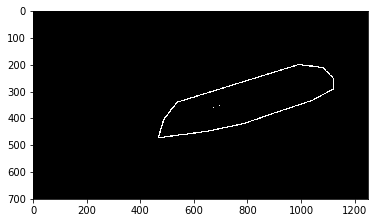

In [50]:
I_mask[list(I_cnt[0]), list(I_cnt[1])] = 255
plt.imshow(I_mask, cmap = 'gray')

In [54]:
I_cnt1, _ = cv2.findContours(I_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
np.array(I_cnt1)

array([[[[987, 197]],

        [[986, 198]],

        [[985, 199]],

        ...,

        [[990, 197]],

        [[989, 197]],

        [[988, 197]]]], dtype=int32)

In [60]:
np.array(I_cnt1).shape

(1, 1420, 1, 2)

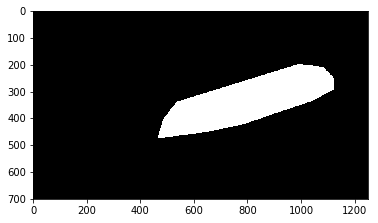

In [56]:
cv2.fillConvexPoly(I_mask, I_cnt1[0], 255)
plt.imshow(I_mask,cmap = 'gray')

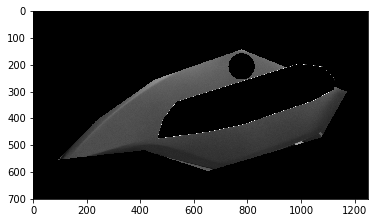

In [58]:
I_mask1 = cv2.bitwise_not(I_mask)
out = cv2.bitwise_and(I_mask1, I[:,:,2])
plt.imshow(out,cmap = 'gray')

In [66]:
temp_list = []
for a, b in zip(I_cnt[0], I_cnt[1]):
    temp_list.append([b, a])

In [67]:
ctr = np.array(temp_list).reshape((-1,1,2)).astype(np.int32)

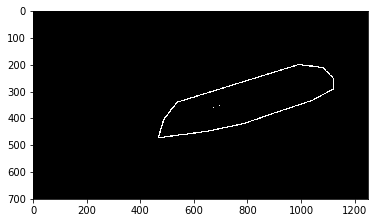

In [68]:
I_mask1 = np.zeros_like(I[:,:,2])
I_mask1[list(I_cnt[0]), list(I_cnt[1])] = 255
plt.imshow(I_mask1, cmap = 'gray')

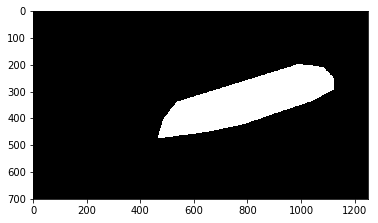

In [69]:
cv2.fillConvexPoly(I_mask1, ctr, 255)
plt.imshow(I_mask1,cmap = 'gray')